# Monitoring of model
 Evaluate model on data and obtain metrics of performance

## Load libraries

In [1]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install lightgbm

In [3]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [6]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve 
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load model and data to evaluate

Load variables names from file

In [8]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [9]:
import os
import joblib
# load model
#modelo = joblib.load("ModeloV2TodosMenosVariables.pkl") 
#variables = open('./ModeloV2TodosMenosVariables.txt','r')
modelo = joblib.load("ModeloFinal2.pkl") 
variables = open('./ModeloFinal2.txt','r')

In [10]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

## Veo si puedo sacar los nombres directo del modelo q cargue
## Veo como cargar el punto de corte

In [11]:
variables = open('./ModeloFinal2.txt','r')
var_input = variables.read()

In [12]:
var_input = ['01_branch_working_days', 'branch_minutes_since_last_transaction',
    'branch_trans_3m', 'branch_has_fraud', 
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist',
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count', '01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [13]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

In [14]:
# Uso esto para sacar el punto de corte. Cuando lo pueda guardar esta celda se va
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')

#saco el punto de corte del primer centil para aplicarlo al test
corte_01 = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()
corte_02 = Y_c.score_rf[Y_c['FRAUD_DECILE']==2].min()
corte_03 = Y_c.score_rf[Y_c['FRAUD_DECILE']==3].min()
corte_04 = Y_c.score_rf[Y_c['FRAUD_DECILE']==4].min()
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==10].min()

In [15]:
corte

1.976573014763343e-08

In [16]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Data2024.parquet")

testeo = pd.concat([X, tes], axis = 0, ignore_index=True)
Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

## Apply model

In [17]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [18]:
testeo['target'].value_counts(dropna=False)

target
False    23561843
True          425
Name: count, dtype: int64

In [19]:
Y_target.shape

(23562268, 8)

In [20]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [21]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [22]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,23561692,151
1,244,181


In [23]:
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,23239591,322252
1,16,409


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='score_rf', ylabel='Count'>

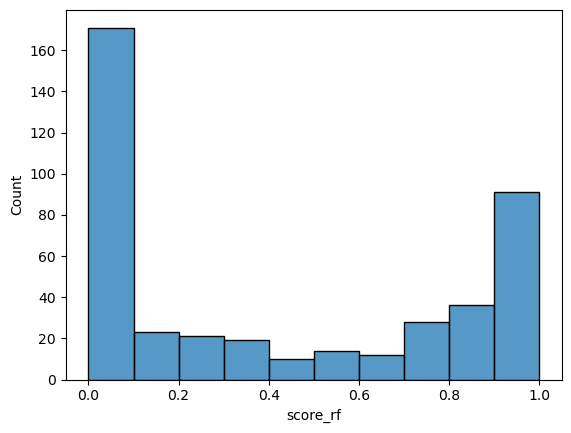

In [24]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [25]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=100, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURA 30%:
0.9647058823529412


In [26]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,235217,406
2,235619,4
3,235623,0
4,235616,6
5,235622,1
...,...,...
96,235623,0
97,235622,0
98,235623,0


In [27]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             3.654930e-08  1.000000e+00
2             9.537545e-09  3.654926e-08
3             4.393617e-09  9.537531e-09
4             2.541944e-09  4.393616e-09
5             1.660518e-09  2.541941e-09
...                    ...           ...
96            5.256978e-13  6.327566e-13
97            4.190809e-13  5.256978e-13
98            3.103282e-13  4.190804e-13
99            1.934784e-13  3.103280e-13
100           1.787409e-15  1.934784e-13

[100 rows x 2 columns]

In [28]:
deciles_semana = Y_c[['day_name_receiver_0', 'day_name_receiver_1',
                   'day_name_receiver_2', 'day_name_receiver_3',
                   'day_name_receiver_4', 'day_name_receiver_5',
                   'day_name_receiver_6',
                 'FRAUD_DECILE']].groupby(['FRAUD_DECILE']).sum()

deciles_semana.head(10)

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6
FRAUD_DECILE,,,,,,,
1,33775,30401,28240,29296,37705,41308,34898
2,33757,29156,26878,27570,38871,43076,36315
3,33777,28801,26264,27355,38891,43882,36653
4,33869,28427,26092,26772,39186,44204,37072
5,33775,28400,25697,26468,39484,44476,37323
6,33655,27786,25516,26302,40242,44545,37577
7,33251,27642,25441,26010,39766,45218,38294
8,33392,27737,25116,26253,40158,45172,37795
9,33915,27370,24808,25936,40451,44990,38153


In [29]:
#PERC = pd.crosstab(Y_c.FRAUD_DECILE[testeo['mes']>8], Y_c.target[testeo['mes']>8])
#PERC.to_csv ('./percentiles.csv')

## Analizo distintos puntos de corte

In [30]:
testeo['date_receiver'].dt.month
testeo['year'] = testeo['date_receiver'].dt.year
Y_c['fraud_classification'] = testeo['fraud_classification']
Y_c['targetF'] = (testeo['fraud_classification']=='Real')

In [31]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_01'] = Y_c['score_rf']>corte_01
tes_corte_01 = testeo[Y_c['pred_corte_01']==True]
Y_c_corte_01 = Y_c[Y_c['pred_corte_01']==True]

pd.crosstab(tes_corte_01['mes'], Y_c_corte_01['targetF'])

targetF,False,True
mes,,
1,10150,82
2,9749,41
3,9546,29
4,2120,61
5,2149,42
6,2027,65
7,2139,30
8,2263,36


In [32]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_02'] = Y_c['score_rf']>corte_02
tes_corte_02 = testeo[Y_c['pred_corte_02']==True]
Y_c_corte_02 = Y_c[Y_c['pred_corte_02']==True]

pd.crosstab(tes_corte_02['mes'], Y_c_corte_02['targetF'])

targetF,False,True
mes,,
1,18654,84
2,17608,45
3,17519,30
4,4256,61
5,4324,44
6,4184,68
7,4303,30
8,4467,37


In [33]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_03'] = Y_c['score_rf']>corte_03
tes_corte_03 = testeo[Y_c['pred_corte_03']==True]
Y_c_corte_03 = Y_c[Y_c['pred_corte_03']==True]

pd.crosstab(tes_corte_03['mes'], Y_c_corte_03['targetF'])

targetF,False,True
mes,,
1,26611,84
2,24580,45
3,24581,30
4,6346,61
5,6487,44
6,6252,68
7,6627,30
8,6667,37


In [34]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_04'] = Y_c['score_rf']>corte_04
tes_corte_04 = testeo[Y_c['pred_corte_04']==True]
Y_c_corte_04 = Y_c[Y_c['pred_corte_04']==True]

pd.crosstab(tes_corte_04['mes'], Y_c_corte_04['targetF'])

targetF,False,True
mes,,
1,34114,84
2,31180,46
3,31526,32
4,8398,61
5,8702,44
6,8313,69
7,8867,30
8,8792,37


In [35]:
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]

pd.crosstab(tes_corte['mes'], Y_c_corte['targetF'])

targetF,False,True
mes,,
1,77514,87
2,66897,46
3,69598,34
4,20724,61
5,22092,45
6,21555,69
7,22319,30
8,21553,37


## Curva ROC y FP

In [36]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [37]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['pred_corte']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['pred_corte'])
recall = recall_score(Y_c[['target']], Y_c['pred_corte'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
9.835289108644135
ROC FRAUD TESTEO:
0.9743380411835406


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.9501902678236264
Precision FRAUD TESTEO:
0.0012675842447646291
Recall FRAUD TESTEO:
0.9623529411764706


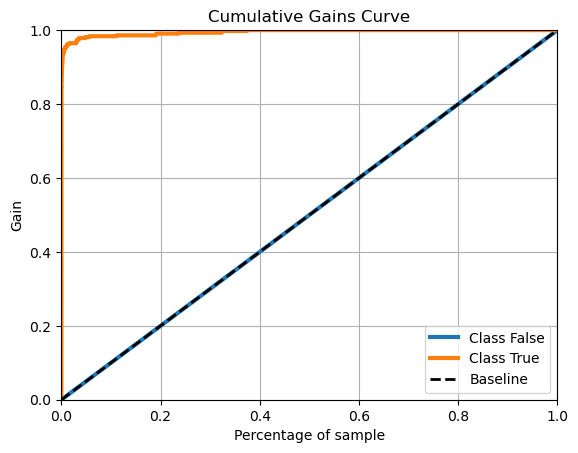

In [38]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


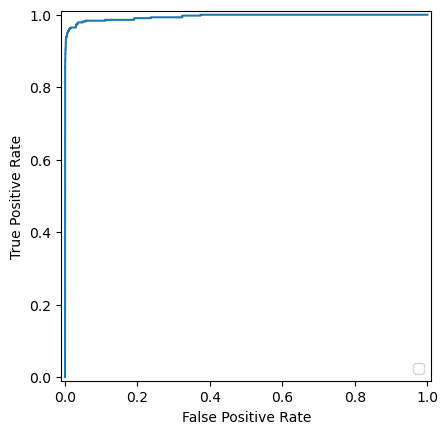

In [39]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

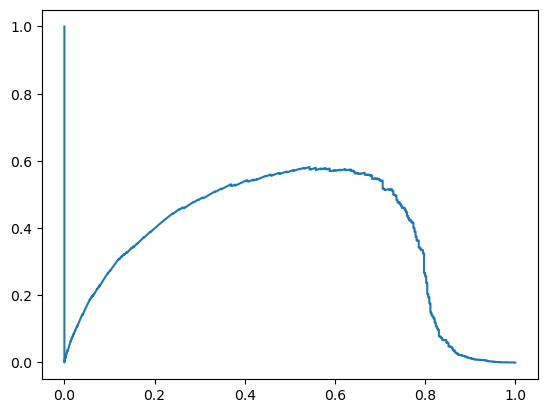

In [40]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(recall, precision)

In [41]:
recall[recall>0.8].min() # 0.8010540184453228
precision[precision>0.8].min() #0.8002832861189801

1.0

## Monthly analysis

In [42]:
pd.crosstab(testeo['mes'], Y_c['target'])

target,False,True
mes,,
1,3794144,90
2,4032029,49
3,4524610,43
4,2116230,61
5,2289916,45
6,2193694,70
7,2314244,30
8,2296976,37


In [43]:
#Veo cuantos falsos positivos tengo con el punto de corte
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]

pd.crosstab(tes_corte['mes'], Y_c_corte['target'])

target,False,True
mes,,
1,77514,87
2,66897,46
3,69598,34
4,20724,61
5,22092,45
6,21555,69
7,22319,30
8,21553,37


In [44]:
Tabla_mes = pd.DataFrame(pd.concat([testeo['mes'],testeo['fraud_classification'], 
                                     Y_c['FRAUD_DECILE'], Y_c['target']],axis=1))

In [45]:
Tabla_mes[Tabla_mes['target']==True]
pd.crosstab(Tabla_mes.mes, Tabla_mes.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
mes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,56977,55452,54045,52597,51219,49993,49062,48555,47290,46485,46148,45131,44732,44949,44655,44127,43917,43500,43913,43030,42792,42828,42678,42212,42340,42226,41649,41818,41366,41097,41230,40825,40756,40874,40732,40383,40094,39973,39901,40015,39697,39377,39204,39261,39144,38957,38870,38566,38046,38118,37779,37719,37304,37418,37182,37046,36605,36363,36443,36180,35701,35635,35820,35186,34705,34743,34524,34231,33841,33434,33584,33496,33211,33273,33102,32512,32154,31877,31569,31674,31318,30877,30978,30957,30230,30213,29892,29358,29155,28951,28442,28217,28105,27963,27762,27481,27050,27074,27089,28005
2,50238,44487,43287,41459,41082,40933,40001,40027,39630,39660,39415,39563,39613,39766,39362,39696,39752,39526,39523,40024,39550,40209,39699,39878,40250,39852,40128,40198,40378,40212,40436,40316,40074,40175,40127,40363,40602,40051,40294,40123,40484,40581,40550,40416,40541,40532,40623,40652,40863,40354,40805,40460,40625,40798,40781,40784,40869,40976,40814,40771,40702,40589,41002,40896,40985,40735,41098,40512,40770,40849,41018,40940,40673,40951,40745,40740,40627,40822,40733,40549,40551,40625,40179,40037,40148,40029,39913,39941,39498,39571,39125,39014,38765,39022,38362,38251,37787,37517,37455,37114
3,51516,48609,46773,46383,45663,44879,44817,44707,44719,44431,44414,44369,44344,44230,44470,44446,44697,44503,44758,44488,44666,44640,44940,45096,44783,44823,44977,44748,44878,44855,44849,44962,45111,44854,45120,45117,45140,45340,45372,45048,45150,45411,45565,45112,45639,45407,44946,45224,45518,45312,45135,45461,45207,45227,45309,45595,45482,45634,45440,44816,45316,45500,45195,45424,45550,45516,45527,46103,45734,45616,45321,45650,45398,45347,45147,45596,45585,45715,45417,45227,45357,45408,45672,45832,45499,45384,45453,45502,45605,45370,45624,45555,45186,45131,44994,44870,44647,44099,43514,42942
4,14964,15944,16400,16846,17157,17529,17460,17788,18124,18160,18390,18251,18234,18262,18591,18374,18503,18896,18426,18681,18806,18483,18244,18455,18750,18432,18647,18690,18662,18844,18971,18922,18824,18793,19017,19117,18949,18963,19369,19151,19168,19176,19318,19247,19209,19672,19636,19424,19764,19738,20017,19867,19771,20050,20082,20105,20367,20340,20665,20843,20900,20890,20845,21076,21138,21225,21175,21654,21679,21744,21879,22219,22238,22567,22746,22755,22875,23090,23594,23664,23897,24104,24385,24689,24851,25405,25574,25858,26537,26829,27178,27345,28051,28550,29100,29702,30562,31116,32203,32874
5,15575,18069,18855,19373,19726,20099,20591,20598,20805,20713,21177,21276,21337,21301,21038,21086,21027,21475,21094,21191,21311,21112,21341,21368,21164,21322,21294,21279,21461,21461,21406,21642,21401,21643,21604,21567,21566,21767,21578,21814,21765,21662,21514,21762,21718,21741,21904,21954,22011,22122,22293,22074,22432,22158,22453,22374,22309,22384,22474,22421,22726,23104,22950,22941,23169,23022,23043,23291,23502,23772,23672,23660,23740,23929,24139,24420,24372,24400,24426,24902,25044,24880,25411,25432,25882,26100,25938,26061,26473,26720,27090,27216,27360,27710,27986,27770,28920,29017,29419,29320
6,15277,17595,18948,19800,20459,20744,21075,21169,21458,22114,21674,22223,22049,21992,21959,22158,22052,22024,21945,22084,22156,21841,22328,22062,21980,22020,22002,22042,21772,22060,22108,21866,21896,22134,21785,21932,22066,22043,22029,22205,21830,22040,21755,21808,21805,21757,21592,21801,21654,21926,21748,21699,22035,21882,21602,21791,21837,21901,21693,22002,21852,21987,21570,21920,21854,21786,21983,22058,22149,22086,22074,21707,22129,21822,22008,21899,22201,22328,22222,22113,22180,22293,22204,22215,22399,22207,22451,22639,22728,22646,22611,22936,23315,22798,23063,23770,236

In [46]:
pd.crosstab(Tabla_mes.mes[Tabla_mes['target']==True], Tabla_mes.FRAUD_DECILE[Tabla_mes['target']==True])

FRAUD_DECILE,1,2,4,5,6,12,20,24,33,38
mes,,,,,,,,,,
1,86,2,0,0,0,0,0,1,0,1
2,46,0,1,0,0,0,2,0,0,0
3,32,2,5,1,0,1,0,0,2,0
4,61,0,0,0,0,0,0,0,0,0
5,45,0,0,0,0,0,0,0,0,0
6,69,0,0,0,1,0,0,0,0,0
7,30,0,0,0,0,0,0,0,0,0
8,37,0,0,0,0,0,0,0,0,0


In [47]:
Tabla_mes.loc[Tabla_mes['target']==True,['mes','fraud_classification','FRAUD_DECILE']]

,mes,fraud_classification,FRAUD_DECILE
18834,1,Real,1
29264,6,Real,1
124527,2,Real,1
357990,3,Real,1
392994,5,Real,1
...,...,...,...
22669385,3,Real,1
22710588,3,Real,1
22822168,3,Real,33
22915992,3,Real,33


# Monthly indicators

In [62]:
i = 0
summary_metrics = pd.DataFrame(columns = ['month','year', 'precision', 'recall','alerts','frauds&dist','frauds','detected'] )
for y in  testeo['year'].unique():
    for m in  testeo['mes'].unique():
        
        subset_mes = Y_c[(testeo['year']==y) & (testeo['mes']==m)]
        if not subset_mes.empty:
            precision = precision_score(subset_mes[['targetF']], subset_mes['pred_corte_02'])
            recall = recall_score(subset_mes[['targetF']], subset_mes['pred_corte_02'])
            summary_metrics.loc[i,'month'] = m
            summary_metrics.loc[i,'year'] = y
            summary_metrics.loc[i,'precision'] = precision
            summary_metrics.loc[i,'recall'] = recall
            summary_metrics.loc[i,'alerts'] = subset_mes['pred_corte_02'].sum()
            summary_metrics.loc[i,'frauds'] = subset_mes['target'].sum()
            summary_metrics.loc[i,'frauds&dist'] = subset_mes['target'].sum()
            summary_metrics.loc[i,'frauds'] = (subset_mes['fraud_classification']=='Real').sum()
            summary_metrics.loc[i,'detected'] = ((subset_mes['pred_corte_02']==True) & (subset_mes['target']==True) & (subset_mes['fraud_classification']=='Real')).sum()
            #print ('Year:', y, 'Month:',m)
            #print ('Precision:', precision, 'Recall:',recall)
            i = i+1
summary_metrics.sort_values(['year','month'])

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.018705,0.984375,3368,64,64,63
0,2,2023,0.008861,1.0,3837,34,34,34
5,3,2023,0.004698,0.954545,4470,22,22,21
1,4,2023,0.01413,1.0,4317,61,61,61
2,5,2023,0.010073,0.977778,4368,45,45,44
3,6,2023,0.015992,0.971429,4252,70,70,68
4,7,2023,0.006924,1.0,4333,30,30,30
7,8,2023,0.008215,1.0,4504,37,37,37
10,1,2024,0.001366,0.807692,15370,26,26,21
8,2,2024,0.000796,0.733333,13816,15,15,11


In [60]:
summary_metrics.sort_values(['year','month'])

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.00367,1.0,17440,64,64,64
0,2,2023,0.001756,1.0,19363,34,34,34
5,3,2023,0.001002,1.0,21960,22,22,22
1,4,2023,0.002935,1.0,20785,61,61,61
2,5,2023,0.002033,1.0,22137,45,45,45
3,6,2023,0.003191,0.985714,21624,70,70,69
4,7,2023,0.001342,1.0,22349,30,30,30
7,8,2023,0.001714,1.0,21590,37,37,37
10,1,2024,0.000382,0.884615,60161,26,26,23
8,2,2024,0.000252,0.8,47580,15,15,12


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


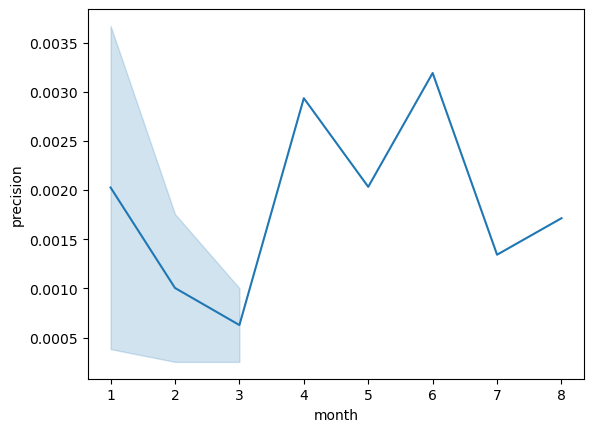

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


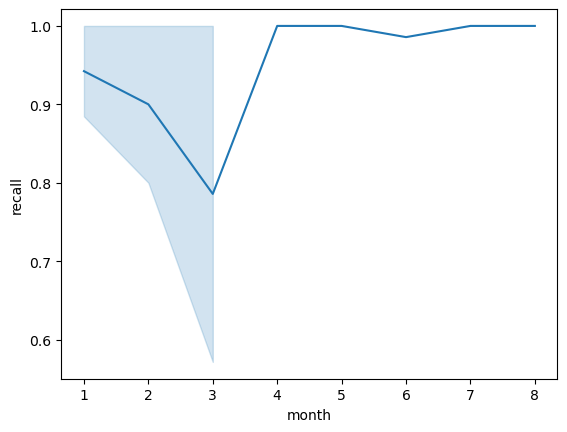

In [61]:
# Recall and precision by month
sns.lineplot(data = summary_metrics, x ='month', y = 'precision')
plt.show()
sns.lineplot(data = summary_metrics, x ='month', y= 'recall')
plt.show()

## Daily analysis

In [ ]:
tes_corte_01['date_receiver'].dt.floor('d')

In [ ]:
ALERTAS_01 = pd.crosstab(tes_corte_01['date_receiver'].dt.floor('d'), Y_c_corte_01['targetF'])
ALERTAS_01.to_csv ('./alertas.csv')

In [ ]:
ALERTAS_01

In [ ]:
FRAUDES = pd.crosstab(testeo['date_receiver'].dt.floor('d'), Y_c['targetF'])
FRAUDES.to_csv ('./fraudes.csv')

In [ ]:
FRAUDES

In [ ]:
Y_c